In [79]:
# ------------------------
# Correlation: Sentiment vs Stock Return
# ------------------------

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau

In [80]:
# ------------------------
# Load Sentiment Data
# ------------------------

sentiment_path = "E:/Tenx/Week 1/Data/cleaned.csv"
sentiment_df = pd.read_csv(sentiment_path)
sentiment_df['date'].isna().sum()

np.int64(0)

In [81]:

# Parse date
# sentiment_df["date"] = pd.to_datetime(sentiment_df["date"]).dt.date

# Average daily sentiment per stock
daily_sentiment = (
    sentiment_df.groupby(["stock", "date"])["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment": "avg_sentiment"})
)


In [94]:
from datetime import datetime

# ------------------------
# Load Stock Price Data (Example: AAPL)
# ------------------------

stock_df = pd.read_csv("../data/yfinance_data/AAPL_historical_data.csv")
stock_df["Date"] = stock_df["Date"].astype(str).str.strip()

# Define a function that tries multiple formats

from datetime import datetime

def try_parse_date(val):
    for fmt in ("%Y-%m-%d", "%Y-%m-%d %H:%M:%S%z", "%m/%d/%Y %H:%M", "%m/%d/%Y"):
        try:
            return datetime.strptime(val, fmt)
        except (ValueError, TypeError):
            continue
    return pd.NaT

stock_df["date_parced"] = stock_df["Date"].astype(str).str.strip().apply(try_parse_date)


# Check results
print("Parsed:", stock_df["date_parced"].notna().sum(), "rows out of", len(stock_df))


Parsed: 10998 rows out of 10998


In [98]:


# compute daily return
stock_df["stock"] = "AAPL"  # Add ticker symbol for merging
stock_df["daily_return"] = stock_df["Close"].pct_change()

# Drop first row with NaN return
stock_df = stock_df.dropna(subset=["daily_return"])

In [101]:
# Convert to datetime format first
sentiment_df["date_parced"] = pd.to_datetime(
    sentiment_df["date_parced"], errors="coerce"
)

# Now extract only the date part
sentiment_df["date_parced"] = sentiment_df["date_parced"].dt.date


In [102]:
stock_df["date_parced"] = pd.to_datetime(
    stock_df["date_parced"], errors="coerce"
)
stock_df["date_parced"] = stock_df["date_parced"].dt.date


C:\Users\betsi\AppData\Local\Temp\ipykernel_17536\456871716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df["date_parced"] = pd.to_datetime(
C:\Users\betsi\AppData\Local\Temp\ipykernel_17536\456871716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df["date_parced"] = stock_df["date_parced"].dt.date


In [103]:
print(sentiment_df["date_parced"].head())
print(sentiment_df["date_parced"].dtype)


0    2020-06-05
1    2020-06-03
2    2020-05-26
3    2020-05-22
4    2020-05-22
Name: date_parced, dtype: object
object


In [104]:
sentiment_df['date'].isna().sum(), sentiment_df['date'].notna().sum()


(np.int64(0), np.int64(1407328))

In [110]:
# Example: Daily average sentiment per stock
daily_sentiment = sentiment_df.groupby(["stock", "date_parced"])["sentiment"].mean().reset_index()
daily_sentiment.rename(columns={"sentiment": "avg_sentiment"}, inplace=True)

# Merge with stock data
merged_df = pd.merge(
    stock_df,
    daily_sentiment,
    left_on=["stock", "date_parced"],
    right_on=["stock", "date_parced"],
    how="inner"
)


In [111]:
print("Missing in avg_sentiment:", merged_df["avg_sentiment"].isna().sum())
print("Missing in daily_return:", merged_df["daily_return"].isna().sum())


Missing in avg_sentiment: 0
Missing in daily_return: 0


In [112]:
# ------------------------
# Correlation Analysis
# ------------------------

# Pearson
pearson_corr, pearson_p = pearsonr(
    merged_df["avg_sentiment"], merged_df["daily_return"]
)

# Spearman
spearman_corr, spearman_p = spearmanr(
    merged_df["avg_sentiment"], merged_df["daily_return"]
)

# Kendall
kendall_corr, kendall_p = kendalltau(
    merged_df["avg_sentiment"], merged_df["daily_return"]
)

print("Correlation Results:")
print(f"Pearson: {pearson_corr:.4f} (p={pearson_p:.4f})")
print(f"Spearman: {spearman_corr:.4f} (p={spearman_p:.4f})")
print(f"Kendall: {kendall_corr:.4f} (p={kendall_p:.4f})")


Correlation Results:
Pearson: 0.1589 (p=0.2213)
Spearman: 0.1826 (p=0.1590)
Kendall: 0.1252 (p=0.1541)


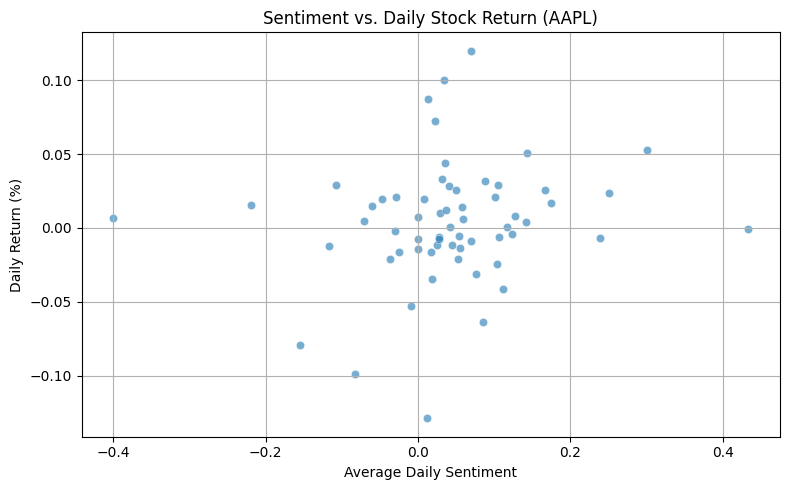

In [113]:
# ------------------------
# Scatter Plot
# ------------------------

plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_df, x="avg_sentiment", y="daily_return", alpha=0.6)
plt.title("Sentiment vs. Daily Stock Return (AAPL)")
plt.xlabel("Average Daily Sentiment")
plt.ylabel("Daily Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()
